In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import (
    rcparams,
    to_nucleons_per_cubic_femtometre,
)
plt.rcParams.update(rcparams)

In [2]:
collated_eos_path = [
    'collated_np_all_post.csv', 
    '/home/isaac.legred/PTAnalysis/Analysis/collated_np_all_post.csv'
    ][0]

In [3]:
# Load the collated EOSs and filter out the ones with zero weight
collated_eos = pd.read_csv(collated_eos_path)
nonzero_collated_eos = collated_eos[collated_eos.logweight_total > -np.inf]

# The pre-computed weights of these EOSs
astro_weights = np.exp(nonzero_collated_eos.logweight_total.values)

In [4]:
ntov_array = to_nucleons_per_cubic_femtometre(nonzero_collated_eos['rhoc(M@Mmax)'])

exclude_mask = ntov_array < 0.16*35

astro_weights = astro_weights[exclude_mask]
ntov_array = ntov_array[exclude_mask]

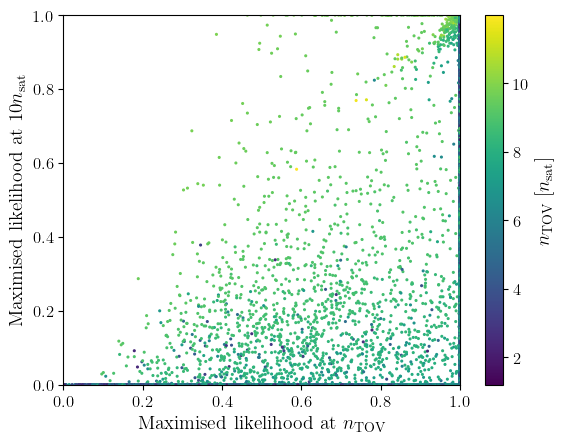

In [5]:
# pQCD likelihood scatter (Xmarg)

nterm_list = ['ntov', 'ns10']
method = 'Xmarg'

likelihood_x = np.loadtxt(f'weights/qcd_weights_{nterm_list[0]}_{method}.dat')
likelihood_y = np.loadtxt(f'weights/qcd_weights_{nterm_list[1]}_{method}.dat')

fig, ax = plt.subplots()

im = ax.scatter(
    likelihood_x[exclude_mask], 
    likelihood_y[exclude_mask], 
    c=ntov_array/0.16, 
    cmap='viridis',
    s=1.5
    )

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.set_xlim(0, 1) # , 1)
ax.set_ylim(0, 1) # , 0.5)

fig.savefig(f'figures/likelihood_scatter_{nterm_list[0]}_{nterm_list[1]}_{method}.pdf')

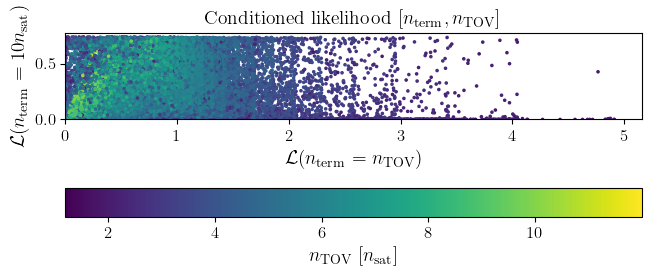

In [21]:
# pQCD likelihood scatter (Xmarg)

nterm_list = ['ntov', 'ns10']
method = 'marg'

likelihood_x = np.loadtxt(f'weights/qcd_weights_{nterm_list[0]}_{method}.dat')
likelihood_y = np.loadtxt(f'weights/qcd_weights_{nterm_list[1]}_{method}.dat')

fig, ax = plt.subplots(layout='constrained')
ax.set_aspect('equal')

im = ax.scatter(
    likelihood_x[exclude_mask], 
    likelihood_y[exclude_mask], 
    c=ntov_array/0.16, 
    cmap='viridis',
    s=2.5
    )

cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_title('Conditioned likelihood $[n_\mathrm{term}, n_\mathrm{TOV}]$')
ax.set_xlabel('$\mathcal{L}(n_\mathrm{term} = n_\mathrm{TOV})$')
ax.set_ylabel('$\mathcal{L}(n_\mathrm{term} = 10n_\mathrm{sat})$')

ax.set_xlim(0)
ax.set_ylim(0)

fig.savefig(f'figures/likelihood_scatter_{nterm_list[0]}_{nterm_list[1]}_{method}.pdf', bbox_inches='tight')